# Eye for Blind – Image Captioning with Attention

# 1. Objective

Eye for Blind: An Assistive Image Captioning System with Visual Attention

This project implements a deep learning model that generates natural language descriptions of images, particularly aimed at visually impaired users. The model leverages an attention mechanism to selectively focus on image regions when generating each word, mimicking human vision.

Inspired by "Show, Attend and Tell" (Xu et al., 2015), this implementation:
1. Uses a CNN encoder (InceptionV3) to extract image features.
2. Applies additive (Bahdanau) attention during decoding.
3. Employs a decoder LSTM to generate captions.
4. Converts generated captions to speech using gTTS.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# 0 (default): All messages (INFO, WARNING, ERROR) are logged.
# 1: INFO messages are not printed.
# 2: INFO and WARNING messages are not printed.
# 3: INFO, WARNING, and ERROR messages are not printed.

import re
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from typing import Dict, List, Tuple, Optional
import tensorflow as tf #type: ignore
from tensorflow.keras import layers, Model #type: ignore
from tensorflow.keras.optimizers.schedules import CosineDecay #type: ignore
from tensorflow.keras.losses import SparseCategoricalCrossentropy #type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer #type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction #type: ignore
from gtts import gTTS #type: ignore
from IPython.display import Audio, display
import tqdm

# 1. CONFIG

In [ ]:
CONFIG: Dict[str, object] = {
    # Data
    'image_dir'            : '/home/flickr8k/Images',
    'caption_file'         : '/home/flickr8k/captions_8k.csv',
    'subset_ratio': 1.0,

    # Vocabulary
    'vocab_min_count': 2,
    'max_length': 30,

    # Model
    'embedding_dim': 512,
    'units': 1024,
    'decoder_dropout': 0.3,

    # Optimiser / schedule
    'learning_rate': 1e-5,  # <<< CRITICAL CHANGE: Reduced learning rate significantly
    'grad_clip_value': 10.0,
    'scheduled_sampling_max_prob': 0.15,
    'mixed_precision': True,  # ← flip to True for AMP

    # Training loop
    'epochs': 50,
    'batch_size': 128,
    'buffer_size': 10_000,
    'early_stop': True,
    'patience': 20,

    # Checkpoints
    'checkpoint_dir': './checkpoints/split_by_image',
    'save_checkpoints': True,
    'delete_old_checkpoints': True,

    # Regulariser
    'attention_reg_lambda': 1.0,
    'seed': 42,
}

# 2. ENV‑SETUP & MIXED‑PRECISION POLICY


In [ ]:
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])
tf.random.set_seed(CONFIG['seed'])

# AMP policy (RTX 6000 Ada or any Tensor Core GPU)
if CONFIG['mixed_precision']:
    try:
        from tensorflow.keras import mixed_precision
    except ImportError:
        raise ImportError("Mixed precision requires TensorFlow ≥ 2.4")

    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("[AMP] mixed_float16 policy active ✨")
else:
    print("[AMP] disabled – using float32 throughout")

# Device placement (single‑GPU)
physical = tf.config.list_physical_devices('GPU')
if physical:
    for gpu in physical:
        tf.config.experimental.set_memory_growth(gpu, True)
    strategy = tf.distribute.get_strategy()
    print(f"Using {physical[0].name} | batch={CONFIG['batch_size']}")
else:
    strategy = tf.distribute.get_strategy()
    print("GPU not found – fallback to CPU")

AUTOTUNE = tf.data.AUTOTUNE

# 3. DATA PROCESSING

In [ ]:
class DataProcessor:
    def __init__(self, config):
        self.config = config
        self.captions_dict: Dict[str, List[str]] = {}
        self.tokenizer: Optional[Tokenizer] = None
        self.vocab_size = 0
        self.train_data: List[Tuple[str, str]] = []
        self.val_data:   List[Tuple[str, str]] = []
        self.test_data:  List[Tuple[str, str]] = []
    
    def load_captions(self) -> Dict[str, List[str]]:
        """Load and convert pipe-delimited Flickr-style caption file to a dict."""
        print(f"Loading captions from {self.config['caption_file']}")
        df = pd.read_csv(self.config['caption_file'], sep='|', header=None, 
                         names=['image_name', 'comment_number', 'comment'], engine='python')
        df['image_name'] = df['image_name'].str.strip()
        df['comment'] = df['comment'].str.strip()
        
        caption_map = {}
        for img, group in df.groupby('image_name'):
            caption_map[img] = group['comment'].tolist()
        
        self.captions_dict = caption_map
        print(f"Loaded {len(caption_map)} images with captions")
        return caption_map
    
    def display_samples(self, num_samples: int = 3):
        """Display random images with all their associated captions."""
        if not self.captions_dict:
            self.load_captions()

        sample_keys = random.sample(list(self.captions_dict.keys()), min(num_samples, len(self.captions_dict)))

        for key in sample_keys:
            img_path = os.path.join(self.config['image_dir'], key)
            try:
                img = Image.open(img_path)
                plt.figure(figsize=(8, 6))
                plt.imshow(img)
                plt.axis('off')
                plt.title(key)
                plt.show()

                for cap in self.captions_dict[key]:
                    print(f"- {cap}")
                print()
            except Exception as e:
                print(f"Error loading image {key}: {e}")

    def preprocess_caption(self, caption: str) -> str:
        """
        Clean and tag a single caption.
        Option A: Allows letters, numbers, and common sentence-ending punctuation, 
        plus apostrophes and hyphens.

        Returns the processed caption string, or an empty string if the
        source caption is None / NaN / not a string.
        """
        if caption is None or not isinstance(caption, str) or caption.strip() == "":
            return ""
        caption = caption.lower()
        # <<< UPDATED LINE FOR OPTION A >>>
        caption = re.sub(r"[^a-z0-9.,?!' -]", "", caption) 
        return f"<start> {caption.strip()} <end>"

    def prepare_captions(self, subset_ratio: float = 1.0):
        """
        Build tokenizer, prune vocab, then create
        (image, caption) pairs and **image-wise** splits.
        """
        if not self.captions_dict:
            self.load_captions()

        # ----- 1. clean + tag all captions -----------------------------------
        all_captions = []
        for caps in self.captions_dict.values():
            for c in caps:
                p = self.preprocess_caption(c)
                if p:
                    all_captions.append(p)

        # ----- 2. vocabulary pruning ----------------------------------------
        word_counts = Counter(w for cap in all_captions for w in cap.split())
        valid_words = {w for w, cnt in word_counts.items()
                       if cnt >= self.config['vocab_min_count']}

        def keep(cap: str) -> bool:
            return all(w in valid_words or w in ('<start>', '<end>')
                       for w in cap.split())

        filtered = [c for c in all_captions if keep(c)]

        # ----- 3. max caption length (95-th percentile) ----------------------
        lengths = [len(c.split()) for c in filtered]
        self.config['max_length'] = int(np.percentile(lengths, 95))
        print(f"max_length set to {self.config['max_length']}")

        # ----- 4. tokenizer ---------------------------------------------------
        tok = Tokenizer(oov_token="<unk>", filters='', lower=True)
        tok.fit_on_texts(filtered)
        self.tokenizer = tok
        self.vocab_size = len(tok.word_index) + 1
        print(f"vocab size = {self.vocab_size}")

        # ----- 5. build ALL (img, caption) pairs ------------------------------
        pairs = []
        for img, caps in self.captions_dict.items():
            for c in caps:
                p = self.preprocess_caption(c)
                if p and keep(p):
                    pairs.append((img, p))

        # ----- 6. optional hard subset of images -----------------------------
        all_imgs = list({img for img, _ in pairs})

        if 'force_subset_images' in self.config and self.config['force_subset_images']:
            wanted = self.config['force_subset_images']
            if wanted > len(all_imgs):
                raise ValueError(f"Requested {wanted} images, only {len(all_imgs)} available.")
            all_imgs = random.sample(all_imgs, wanted)
            print(f"Forced subset → {wanted} images")

        elif subset_ratio < 1.0:
            k = int(len(all_imgs) * subset_ratio)
            all_imgs = random.sample(all_imgs, k)
            print(f"Subset ratio {subset_ratio:.2f} → {k} images")

        # keep only pairs whose image made the cut
        img_set = set(all_imgs)
        pairs = [(img, cap) for img, cap in pairs if img in img_set]

        # ----- 7. IMAGE-WISE shuffle + split ----------------------------------
        random.shuffle(all_imgs)
        n = len(all_imgs)
        n_train = int(0.9 * n)
        n_val   = int(0.05 * n)
        train_imgs = set(all_imgs[:n_train])
        val_imgs   = set(all_imgs[n_train:n_train + n_val])
        test_imgs  = set(all_imgs[n_train + n_val:])

        def assign(target_set):
            return [(img, cap) for img, cap in pairs if img in target_set]

        self.train_data = assign(train_imgs)
        self.val_data   = assign(val_imgs)
        self.test_data  = assign(test_imgs)

        print(f"split (by image) → "
              f"train {len(train_imgs)} imgs / {len(self.train_data)} pairs | "
              f"val {len(val_imgs)} / {len(self.val_data)} | "
              f"test {len(test_imgs)} / {len(self.test_data)}")

        return filtered

        
    def encode_caption(self, caption: str) -> Tuple[np.ndarray, int]:
        """Convert caption text to sequence of token ids."""
        if self.tokenizer is None:
            raise ValueError("Tokenizer not initialized. Call prepare_captions first.")
        
        seq = self.tokenizer.texts_to_sequences([caption])[0]
        padded_seq = pad_sequences([seq], maxlen=self.config['max_length'], padding='post')[0]
        return padded_seq, len(seq)

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def _base_decode(self, path: tf.Tensor) -> tf.Tensor:
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)          # [0,1]
        return img                                                   # (h,w,3)

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def load_image_train(self, path: tf.Tensor) -> tf.Tensor:
        """Augment + preprocess (training only)."""
        img = self._base_decode(path)
        img = tf.image.random_flip_left_right(img)                   # aug ①

        # resize shorter side→342 then *random* crop 299×299
        shape = tf.shape(img)[:2]
        scale = 342. / tf.cast(tf.reduce_min(shape), tf.float32)
        new_hw = tf.cast(tf.cast(shape, tf.float32) * scale, tf.int32)
        img = tf.image.resize(img, new_hw)
        img = tf.image.random_crop(img, size=[299, 299, 3])          # aug ②

        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return tf.ensure_shape(img, [299, 299, 3])

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def load_image_eval(self, path: tf.Tensor) -> tf.Tensor:
        """Deterministic centre-crop (validation / inference)."""
        img = self._base_decode(path)

        # resize shorter side→342 then *central* crop 299×299
        shape = tf.shape(img)[:2]
        scale = 342. / tf.cast(tf.reduce_min(shape), tf.float32)
        new_hw = tf.cast(tf.cast(shape, tf.float32) * scale, tf.int32)
        img = tf.image.resize(img, new_hw)
        img = tf.image.resize_with_crop_or_pad(img, 299, 299)

        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return tf.ensure_shape(img, [299, 299, 3])

    def data_generator(self, data):
        """
        Yield (image_tensor, token_ids, caption_len, filename)
        so the filename is always available for debug/analysis.
        """
        for img, cap in data:
            img_path  = os.path.join(self.config['image_dir'], img)
            img_tensor = self.load_image_train(tf.convert_to_tensor(img_path))
            token_ids, cap_len = self.encode_caption(cap)
            yield img_tensor, token_ids, cap_len, img 
    
    def build_dataset(self, data,
                      shuffle=True, cache=True, training: bool = True):

        output_signature = (
            tf.TensorSpec((299, 299, 3), tf.float32),               # image
            tf.TensorSpec((self.config['max_length'],), tf.int32),  # token ids
            tf.TensorSpec((), tf.int32),                            # caption len
            tf.TensorSpec((), tf.string)                            # filename
        )

        ds = tf.data.Dataset.from_generator(
            lambda: self.data_generator(data),
            output_signature=output_signature)

        if cache:
            ds = ds.cache()
        if shuffle:
            ds = ds.shuffle(self.config['buffer_size'])

        ds = ds.batch(self.config['batch_size'])
        ds = ds.prefetch(AUTOTUNE)
        return ds

    def prepare_datasets(self):
        """Prepare all datasets for training/validation/testing."""
        if not self.train_data:
            self.prepare_captions()

        print("Building datasets...")
        train_ds = self.build_dataset(self.train_data)
        val_ds = self.build_dataset(self.val_data)
        test_ds = self.build_dataset(self.test_data, shuffle=False)
        
        return train_ds, val_ds, test_ds

# 4. MODEL BUILDING BLOCKS

In [ ]:
class Encoder(Model):
    """Encoder: Fully trainable Inception‑V3 feature extractor."""

    def __init__(self):
        super().__init__(name="encoder")
        base = tf.keras.applications.InceptionV3(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3))
        # Making the entire base model trainable from the start
        base.trainable = True 
        self.cnn = Model(inputs=base.input,
                         outputs=base.get_layer('mixed10').output)
        self.reshape = layers.Reshape((-1, 2048))  # (B,64,2048)

    def call(self, x):                  # (B,299,299,3)
        x = self.cnn(x)                 # (B,8,8,2048)
        return self.reshape(x)

In [ ]:
class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super().__init__(name="attention")
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V  = layers.Dense(1)

    def call(self, features, hidden):
        hidden_time = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_time)))
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(weights * features, axis=1)
        return context, tf.squeeze(weights, -1)

In [ ]:
class Decoder(Model):
    """Attention‑based LSTM decoder with AMP‑safe logits."""

    def __init__(self, embedding_dim: int, units: int,
                 vocab_size: int, dropout: float = 0.5):
        super().__init__(name="decoder")
        self.units = units

        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.attention = BahdanauAttention(units)
        self.f_beta    = layers.Dense(1, activation='sigmoid')
        self.lstm      = layers.LSTM(units, return_sequences=True,
                                     return_state=True)
        self.dropout   = layers.Dropout(dropout)

        self.deep_proj = layers.Dense(units * 2)
        # Force float32 logits for numerical stability under AMP
        self.fc        = layers.Dense(vocab_size, dtype='float32')

    def call(self, x, features, hidden, cell):
        context, alpha = self.attention(features, hidden)
        context = self.f_beta(hidden) * context

        x = self.embedding(x)
        lstm_input = tf.concat([tf.expand_dims(context, 1), x], -1)

        hidden = tf.cast(hidden, lstm_input.dtype)
        cell   = tf.cast(cell, lstm_input.dtype)

        lstm_out, h_t, c_t = self.lstm(lstm_input, initial_state=[hidden, cell])
        lstm_out = tf.squeeze(lstm_out, 1)

        proj = self.deep_proj(tf.concat([lstm_out, context], -1))
        proj = tf.reshape(proj, (-1, self.units, 2))
        maxout = tf.reduce_max(proj, axis=-1)
        maxout = self.dropout(maxout)

        logits = self.fc(maxout)  #  ← float32 regardless of global policy
        return tf.expand_dims(logits, 1), h_t, c_t, alpha

In [ ]:
class TextToSpeech:
    """
    A utility class to convert text to speech using gTTS and play it.
    """
    def __init__(self):
        try:
            from gtts import gTTS
            from IPython.display import Audio, display
            self.gTTS = gTTS
            self.Audio = Audio
            self.display = display
        except ImportError:
            print("WARNING: gTTS or IPython.display not found. Speech functionality will be disabled.")
            self.gTTS = None
            self.Audio = None
            self.display = None

    def speak(self, text: str, filename: str = "caption_audio.mp3"):
        """Generate speech audio from text and play it."""
        if not text:
            print("Empty text, nothing to speak.")
            return
        
        if self.gTTS is None:
            print("Text-to-speech functionality is not available. Please install 'gtts' and ensure running in an IPython environment.")
            return

        try:
            tts = self.gTTS(text=text, lang='en')
            tts.save(filename)
            self.display(self.Audio(filename))
            print(f"Audio saved to {filename}")
        except Exception as e:
            print(f"Error generating or playing audio: {e}")

# 5. TOP‑LEVEL TRAINING WRAPPER (AMP READY)

In [ ]:
class ImageCaptioningModel:
    def __init__(self, config, processor):
        self.config    = config
        self.processor = processor

        self.encoder      = None
        self.decoder      = None
        self.optimizer    = None
        self.loss_fn      = None
        self.ckpt_manager = None
        self.tts_speaker  = TextToSpeech() # Initialize TextToSpeech here

        # Logs
        self.best_bleu      = 0.0
        self.train_loss_log = []
        self.train_bleu_log = []
        self.val_bleu_log   = []
        self.bleu_subset_idx: Optional[List[int]] = None
        self.grad_norm_log: List[float] = []

        self.smoothie = SmoothingFunction().method4

    def _cast_logits(self, logits):
        """Helper: safely cast logits for softmax / log‑softmax."""
        return tf.cast(logits, tf.float32) if logits.dtype != tf.float32 else logits

    # ────────────────────────────────────────────────────────────────────
    # BUILD
    # ────────────────────────────────────────────────────────────────────
    def build_model(self):
        print("Building model …")
        self.encoder = Encoder()
        self.decoder = Decoder(
            embedding_dim=self.config['embedding_dim'],
            units=self.config['units'],
            vocab_size=self.processor.vocab_size,
            dropout=self.config.get('decoder_dropout', 0.5)
        )

        lr_schedule = CosineDecay(
            initial_learning_rate=self.config['learning_rate'],
            decay_steps=50_000)

        if self.config['mixed_precision']:
            base_opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
            # automatic loss-scaling for AMP
            self.optimizer = tf.keras.mixed_precision.LossScaleOptimizer(base_opt)
        else:
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        self.loss_fn = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

        # Checkpointing
        if not self.config.get('save_checkpoints', True):
            print("Checkpointing disabled.")
            return

        ckpt = tf.train.Checkpoint(encoder=self.encoder,
                                   decoder=self.decoder,
                                   optimizer=self.optimizer)
        ckpt_dir = self.config['checkpoint_dir']
        os.makedirs(ckpt_dir, exist_ok=True)
        self.ckpt_manager = tf.train.CheckpointManager(
            ckpt, ckpt_dir,
            max_to_keep=1 if self.config.get('delete_old_checkpoints', True) else 5)

        if self.ckpt_manager.latest_checkpoint:
            ckpt.restore(self.ckpt_manager.latest_checkpoint)
            print("Restored:", self.ckpt_manager.latest_checkpoint)
    
    def summary(self):
        """Print model summaries for Encoder, Attention, and Decoder."""
        print("Building model summaries...")

        # Dummy inputs
        dummy_image = tf.random.uniform((1, 299, 299, 3))
        dummy_features = tf.random.uniform((1, 64, 2048))
        dummy_hidden = tf.zeros((1, self.config['units']))
        dummy_cell = tf.zeros((1, self.config['units']))
        dummy_token = tf.zeros((1, 1), dtype=tf.int32)

        # Ensure encoder is built before summarizing
        _ = self.encoder(dummy_image) 
        print("\nEncoder Summary:")
        self.encoder.summary()

        # Bahdanau Attention Summary - still uses a dummy instance for summary
        print("\nBahdanau Attention Summary:")
        attention_layer = BahdanauAttention(self.config['units'])
        features_input = tf.keras.Input(shape=(64, 2048), name="features")
        hidden_input = tf.keras.Input(shape=(self.config['units'],), name="hidden")
        context_vector, attn_weights = attention_layer(features_input, hidden_input)
        attention_model = tf.keras.Model(inputs=[features_input, hidden_input], outputs=[context_vector, attn_weights])
        attention_model.summary()

        # Ensure decoder is built before summarizing
        _ = self.decoder(dummy_token, dummy_features, dummy_hidden, dummy_cell)
        print("\nDecoder Summary:")
        self.decoder.summary()

    # ────────────────────────────────────────────────────────────────────
    # TRAIN STEP (handles loss‑scaling)
    # ────────────────────────────────────────────────────────────────────
    @tf.function
    def train_step(self, img_tensor, target, cap_len):
        batch_size = tf.shape(img_tensor)[0]

        with tf.GradientTape() as tape:
            # forward ──────────────────────────────────────────────────────────
            features   = self.encoder(img_tensor)        # (B,L,2048)  fp16 when AMP
            feat_dtype = features.dtype

            hidden = tf.zeros((batch_size, self.config['units']), dtype=feat_dtype)
            cell   = tf.zeros_like(hidden)

            start_tok = self.processor.tokenizer.word_index['<start>']
            dec_input = tf.expand_dims(tf.repeat(start_tok, batch_size), 1)

            L             = tf.shape(features)[1]
            attn_accum    = tf.zeros((batch_size, L), dtype=feat_dtype)
            total_ce_loss = tf.constant(0.0, dtype=tf.float32)   # stay fp32

            ce_t = tf.constant(0.0, dtype=tf.float32)            # dummy init

            for t in tf.range(1, self.config['max_length']):
                logits, hidden, cell, alpha = self.decoder(dec_input, features, hidden, cell)
                attn_accum += alpha

                ce_t   = self.loss_fn(target[:, t], tf.squeeze(logits, 1))   # fp32
                mask   = tf.cast(target[:, t] > 0, tf.float32)
                total_ce_loss += tf.reduce_sum(ce_t * mask)

                pred_ids = tf.argmax(logits, -1, output_type=tf.int32)[:, 0]

                ss_mask  = tf.random.uniform([batch_size], dtype=tf.float32)
                ss_mask  = ss_mask < self.ss_prob
                next_ids = tf.where(ss_mask, pred_ids, target[:, t])

                dec_input = tf.expand_dims(next_ids, 1)

            total_tokens = tf.reduce_sum(tf.cast(cap_len, tf.float32))
            ce_loss      = total_ce_loss / total_tokens
            reg_loss     = tf.reduce_mean(tf.square(1.0 - tf.cast(attn_accum, tf.float32)))
            loss         = ce_loss + self.config.get('attention_reg_lambda', 1.0) * reg_loss

            # ---- explicit loss-scaling when the optimiser is a LossScaleOptimizer
            if isinstance(self.optimizer, tf.keras.mixed_precision.LossScaleOptimizer):
                loss_for_grad = self.optimizer.get_scaled_loss(loss)
            else:
                loss_for_grad = loss

        # backward ──────────────────────────────────────────────────────────────
        variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        grads     = tape.gradient(loss_for_grad, variables)

        if isinstance(self.optimizer, tf.keras.mixed_precision.LossScaleOptimizer):
            grads = self.optimizer.get_unscaled_gradients(grads)

        grads, _ = tf.clip_by_global_norm(grads, self.config['grad_clip_value'])
        self.optimizer.apply_gradients(zip(grads, variables))

        grad_norm = tf.linalg.global_norm(grads)
        return loss, grad_norm

    def beam_search_decode(self, image_path: str, beam_size: int = 5,
                           length_penalty: float = 0.7,
                           return_attention: bool = False):
        img_tensor = tf.expand_dims(
            self.processor.load_image_eval(tf.convert_to_tensor(image_path)), 0)
        base_feat = self.encoder(img_tensor)
        start_id = self.processor.tokenizer.word_index['<start>']
        end_id   = self.processor.tokenizer.word_index['<end>']

        beams = [{'seq':[start_id], 'score':0.0,
                  'hidden':tf.zeros((1, self.config['units'])),
                  'cell':tf.zeros((1, self.config['units'])),
                  'alphas':[]}]
        completed = []

        for _ in range(self.config['max_length']):
            cand = []
            for b in beams:
                last = b['seq'][-1]
                if last == end_id:
                    completed.append(b); continue
                dec_in = tf.expand_dims([last], 0)
                logits, h, c, alpha = self.decoder(dec_in, base_feat,
                                                   b['hidden'], b['cell'])
                log_p = tf.nn.log_softmax(self._cast_logits(logits[0, 0]))
                top = tf.math.top_k(log_p, k=beam_size).indices.numpy()
                for tok in top:
                    tok = int(tok)
                    cand.append({'seq': b['seq']+[tok],
                                 'score': b['score']+float(log_p[tok]),
                                 'hidden': h, 'cell': c,
                                 'alphas': b['alphas']+[alpha[0].numpy()]})
            if not cand:
                break
            cand.sort(key=lambda x: x['score']/(len(x['seq'])**length_penalty),
                       reverse=True)
            beams = cand[:beam_size]
            if len(completed) >= beam_size:
                break

        best = max(completed+beams,
                    key=lambda b: b['score']/(len(b['seq'])**length_penalty))
        words = [self.processor.tokenizer.index_word.get(i, '')
                 for i in best['seq']
                 if self.processor.tokenizer.index_word.get(i, '') not in
                 ('<start>', '<end>', '<unk>')]
        return (words, best['alphas']) if return_attention else words

    def greedy_decode(self, image_path: str, return_attention=False):
        img_tensor = tf.expand_dims(
            self.processor.load_image_eval(tf.convert_to_tensor(image_path)), 0)
        feat = self.encoder(img_tensor)
        hidden = tf.zeros((1, self.config['units']))
        cell   = tf.zeros_like(hidden)
        dec_in = tf.expand_dims([self.processor.tokenizer.word_index['<start>']], 0)

        words, alphas = [], []
        for _ in range(self.config['max_length']):
            logits, hidden, cell, alpha = self.decoder(dec_in, feat, hidden, cell)
            pred = tf.argmax(self._cast_logits(logits[0, 0])).numpy()
            word = self.processor.tokenizer.index_word.get(pred, '')
            if word == '<end>':
                break
            if word not in ('<start>', '<unk>'):
                words.append(word)
            alphas.append(alpha[0].numpy())
            dec_in = tf.expand_dims([pred], 0)

        return (words, alphas) if return_attention else words

    def evaluate_bleu(self, data, max_samples: int = None):
        """
        Compute BLEU-1 … BLEU-4 for the given (image, caption) dataset,
        gracefully skipping empty / malformed GT captions.
        """
        refs, hyps = [], []
        subset = data[:max_samples] if max_samples else data

        for img_name, _ in tqdm.tqdm(subset, desc="BLEU evaluation"):
            # ── hypothesis ─────────────────────────────────────────────────────
            img_path = os.path.join(self.config['image_dir'], img_name)
            hyp_tokens = self.greedy_decode(img_path)          # list[str]

            # ── references ────────────────────────────────────────────────────
            gt_tokens = []
            for raw_cap in self.processor.captions_dict.get(img_name, [])[:5]:
                pc = self.processor.preprocess_caption(raw_cap)
                if not pc:                                     # bad / empty caption
                    continue
                tokens = [w for w in pc.split()
                        if w not in ("<start>", "<end>")]
                if tokens:                                     # keep non-empty refs
                    gt_tokens.append(tokens)

            if not gt_tokens:                                  # nothing usable
                continue

            refs.append(gt_tokens)
            hyps.append(hyp_tokens)

        if not refs:
            raise RuntimeError("No valid reference captions were found")

        # ── BLEU-n for n = 1…4 ───────────────────────────────────────────────
        bleu = {}
        for n in range(1, 5):
            weights = (1.0 / n,) * n + (0.0,) * (4 - n)
            bleu[f"bleu-{n}"] = corpus_bleu(
                refs, hyps, weights=weights, smoothing_function=self.smoothie
            )
            print(f"BLEU-{n}: {bleu[f'bleu-{n}']:.4f}")

        return bleu

    def train(self, train_ds, val_data, epochs=None,
              subset_size: int = 200):

        if epochs is None:
            epochs = self.config['epochs']

        if self.bleu_subset_idx is None:
            total_train = len(self.processor.train_data)
            subset_size = min(subset_size, total_train)
            self.bleu_subset_idx = random.sample(range(total_train), subset_size)

        def _subset(data, idx):
            return [data[i] for i in idx]

        patience         = self.config.get('patience', 8)
        wait             = 0
        apply_early_stop = self.config.get('early_stop', True)
        self.ss_max_prob = self.config.get('scheduled_sampling_max_prob', 0.0)

        self.grad_norm_log = []        # fresh log each train() call

        # ── epoch loop ─────────────────────────────────────────────────────
        for epoch in range(epochs):
            self.ss_prob = self.ss_max_prob * (epoch / max(1, epochs - 1))
            print(f"\nEpoch {epoch+1}/{epochs} (ε={self.ss_prob:.3f})")

            start_time       = time.time()
            total_loss       = 0.0
            latest_grad_norm = 0.0

            prog = tf.keras.utils.Progbar(None, stateful_metrics=['loss'])

            # ── batch loop ───────────────────────────────────────────────
            for batch, (img, tgt, cap_len, _) in enumerate(train_ds):
                if batch == 0 and prog.target is None:
                    prog.target = (len(self.processor.train_data)
                                   // self.config['batch_size'] + 1)

                batch_loss, batch_norm = self.train_step(img, tgt, cap_len)

                total_loss       += float(batch_loss)
                latest_grad_norm  = float(batch_norm)
                self.grad_norm_log.append(latest_grad_norm)

                prog.update(batch + 1, values=[('loss', batch_loss)])

            avg_loss = total_loss / (batch + 1)
            self.train_loss_log.append(avg_loss)

            # ── quick BLEU on fixed subset ───────────────────────────────
            train_subset = _subset(self.processor.train_data, self.bleu_subset_idx)
            train_bleu   = self.evaluate_bleu(train_subset)['bleu-4']
            val_bleu     = self.evaluate_bleu(val_data)['bleu-4']
            self.train_bleu_log.append(train_bleu)
            self.val_bleu_log.append(val_bleu)

            if self.ckpt_manager:
                self.ckpt_manager.save()

            # ── early-stop check ─────────────────────────────────────────
            if val_bleu > self.best_bleu:
                self.best_bleu = val_bleu
                wait = 0
            else:
                wait += 1
                if apply_early_stop and wait >= patience:
                    print(f"Early stopping (no BLEU gain for {wait} epochs)")
                    break

            #  **safe LR readout** (works for schedule *or* constant) 
            lr_obj = self.optimizer.learning_rate
            if callable(lr_obj):
                lr_now = float(lr_obj(self.optimizer.iterations).numpy())
            else:
                lr_now = float(tf.keras.backend.get_value(lr_obj))
            # ↑↑↑---------------------------------------------------------↑↑↑

            print(f"Epoch {epoch+1}: "
                  f"loss={avg_loss:.4f}  "
                  f"trainBLEU={train_bleu:.4f}  valBLEU={val_bleu:.4f}  "
                  f"lr={lr_now:.2e}  "
                  f"time={time.time() - start_time:.1f}s")

        return self.train_loss_log, self.val_bleu_log


    def plot_attention(self, image_path: str, caption: list, alphas: list):
        """Improved visualization of attention with better contrast and 299x299 alignment."""
        img = np.array(Image.open(image_path).resize((299, 299)))
        fig = plt.figure(figsize=(15, 8))

        for t in range(len(caption)):
            ax = fig.add_subplot(3, int(np.ceil(len(caption) / 3)), t + 1)
            ax.imshow(img)
            ax.axis('off')

            alpha = np.array(alphas[t])
            attention_shape = int(np.sqrt(alpha.size))
            alpha = alpha.reshape((attention_shape, attention_shape))

            # Normalize and boost contrast
            alpha -= alpha.min()
            if alpha.max() > 0:
                alpha /= alpha.max()

            # Resize attention map to 299×299
            alpha_resized = Image.fromarray(np.uint8(255 * alpha)).resize((299, 299), resample=Image.BICUBIC)
            alpha_resized = np.array(alpha_resized) / 255.0  # back to [0,1] float

            ax.imshow(alpha_resized, cmap='jet', alpha=0.5, extent=(0, 299, 299, 0))
            ax.set_title(f"{t+1}: '{caption[t]}'", fontsize=10)

        plt.tight_layout()
        plt.show()

    def plot_history(self):
        """Plot loss curve **and** both train/val BLEU-4 curves."""
        plt.figure(figsize=(14, 5))

        # --- left: training loss ---
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss_log, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Cross-Entropy Loss')
        plt.title('Training Loss')
        plt.grid(True)
        plt.legend()

        # --- right: BLEU-4 ---
        plt.subplot(1, 2, 2)
        if self.train_bleu_log:
            plt.plot(self.train_bleu_log, label='Train BLEU-4')
        plt.plot(self.val_bleu_log,   label='Val BLEU-4')
        plt.xlabel('Epoch')
        plt.ylabel('BLEU-4')
        plt.title('BLEU-4 Scores')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()
    
    def speak_caption(self, caption: str, filename="caption_audio.mp3"):
        """Generate speech audio from caption text."""
        self.tts_speaker.speak(caption, filename)
    
    def demo(
            self,
            image_path: str,
            filename: str = "caption_audio.mp3",
            beam_size: int = 5,
            length_penalty: float = 0.7):
        """
        End-to-end demo (beam-search inference):

        1. Original image  – now titled with the **filename**
        2. Ground-truth captions
        3. Generated caption
        4. Audio playback
        5. Attention heat-maps
        """
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            return

        # ---------------- 1. original image ----------------
        img_name = os.path.basename(image_path)              # <- filename for the title
        img = Image.open(image_path)

        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(img_name, fontsize=14, pad=10)             # <- show filename here
        plt.axis('off')
        plt.show()

        # ---------------- 2. ground-truth captions ----------
        gt_caps = self.processor.captions_dict.get(img_name, [])
        if gt_caps:
            print("Ground-truth captions:")
            for cap in gt_caps:
                print(" -", cap)
        else:
            print("No ground-truth captions found.")

        # ---------------- 3. caption generation -------------
        words, attention = self.beam_search_decode(
            image_path,
            beam_size=beam_size,
            length_penalty=length_penalty,
            return_attention=True
        )
        caption = " ".join(words)
        print("\nGenerated caption:")
        print(caption)

        # ---------------- 4. audio --------------------------
        self.speak_caption(caption, filename=filename)

        # ---------------- 5. attention plot ----------------
        self.plot_attention(image_path, words, attention)

    def prime_dataset(self, ds, steps: int = None) -> None:
        """
        Pre-fill a tf.data shuffle buffer so the first training epoch
        starts without the usual “Filling up shuffle buffer …” pause.

        Args
        ----
        ds    : the *un-iterated* tf.data.Dataset you’ll pass to train()
        steps : number of iterator steps to advance; default uses
                buffer_size // batch_size + 1 from config.
        """
        if steps is None:
            steps = self.config['buffer_size'] // self.config['batch_size'] + 1

        it = iter(ds)
        for _ in range(steps):
            try:
                next(it)
            except StopIteration:  # dataset shorter than requested priming
                break

    # fine_tune_cnn method is removed as discussed

    def plot_grad_norms(self):
        """Simple line plot of gradient norms per batch."""
        if not self.grad_norm_log:
            print("No grad-norm data logged yet.")
            return
        plt.figure(figsize=(8,4))
        plt.plot(self.grad_norm_log)
        plt.xlabel('Update step')
        plt.ylabel('Global grad norm')
        plt.title('Gradient-norm trajectory')
        plt.grid(True)
        plt.show()

In [ ]:
processor = DataProcessor(CONFIG)

In [ ]:
_ = processor.load_captions()

In [ ]:
processor.display_samples(1)

In [ ]:
processor.prepare_captions(subset_ratio=CONFIG['subset_ratio'])[:20]

In [ ]:
train_ds, val_ds, _ = processor.prepare_datasets()

In [ ]:
model = ImageCaptioningModel(CONFIG, processor)
model.build_model()

In [ ]:
model.summary()

In [ ]:
model.prime_dataset(ds=train_ds, steps=50)

In [ ]:
reduced_val = random.sample(processor.val_data, min(len(processor.val_data), 1000))

In [ ]:
model.train(train_ds=train_ds, val_data=reduced_val)

In [ ]:
model.plot_grad_norms()

In [ ]:
model.plot_history()

In [ ]:
# model.evaluate_bleu(processor.test_data)

In [39]:
samples = processor.train_data[:5]  # known to be from training set
for img_name, _ in samples:
    img_path = os.path.join(CONFIG['image_dir'], img_name)
    pred = model.greedy_decode(img_path)
    print ('------------')
    print("Predicted:", ' '.join(pred))
    print("Ground Truth:", processor.captions_dict[img_name][:1])

------------
Predicted: a man in a red shirt is standing on a street .
Ground Truth: ['A child in a pink dress is climbing up a set of stairs in an entry way .']
------------
Predicted: a man in a red shirt is standing on a street .
Ground Truth: ['A child in a pink dress is climbing up a set of stairs in an entry way .']
------------
Predicted: a man in a red shirt is standing on a street .
Ground Truth: ['A child in a pink dress is climbing up a set of stairs in an entry way .']
------------
Predicted: a man in a red shirt is standing on a street .
Ground Truth: ['A child in a pink dress is climbing up a set of stairs in an entry way .']
------------
Predicted: a black dog is running in the grass .
Ground Truth: ['A black dog and a spotted dog are fighting']


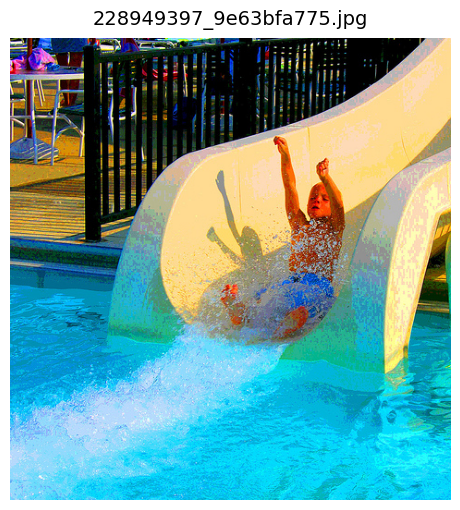

Ground-truth captions:
 - A kid is going down a big water slide .
 - A kid slides down a yellow slide into a swimming pool .
 - A person is coming down a yellow water slide into a pool .
 - A young boy about to enter a pool after sliding down a yellow slide .
 - Child sliding down slide into pool of water .

Generated caption:
a black and white dog is running on a grass .


Audio saved to caption_audio01.mp3


/tmp/ipykernel_16150/2224873464.py:385: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  alpha_resized = Image.fromarray(np.uint8(255 * alpha)).resize((299, 299), resample=Image.BICUBIC)


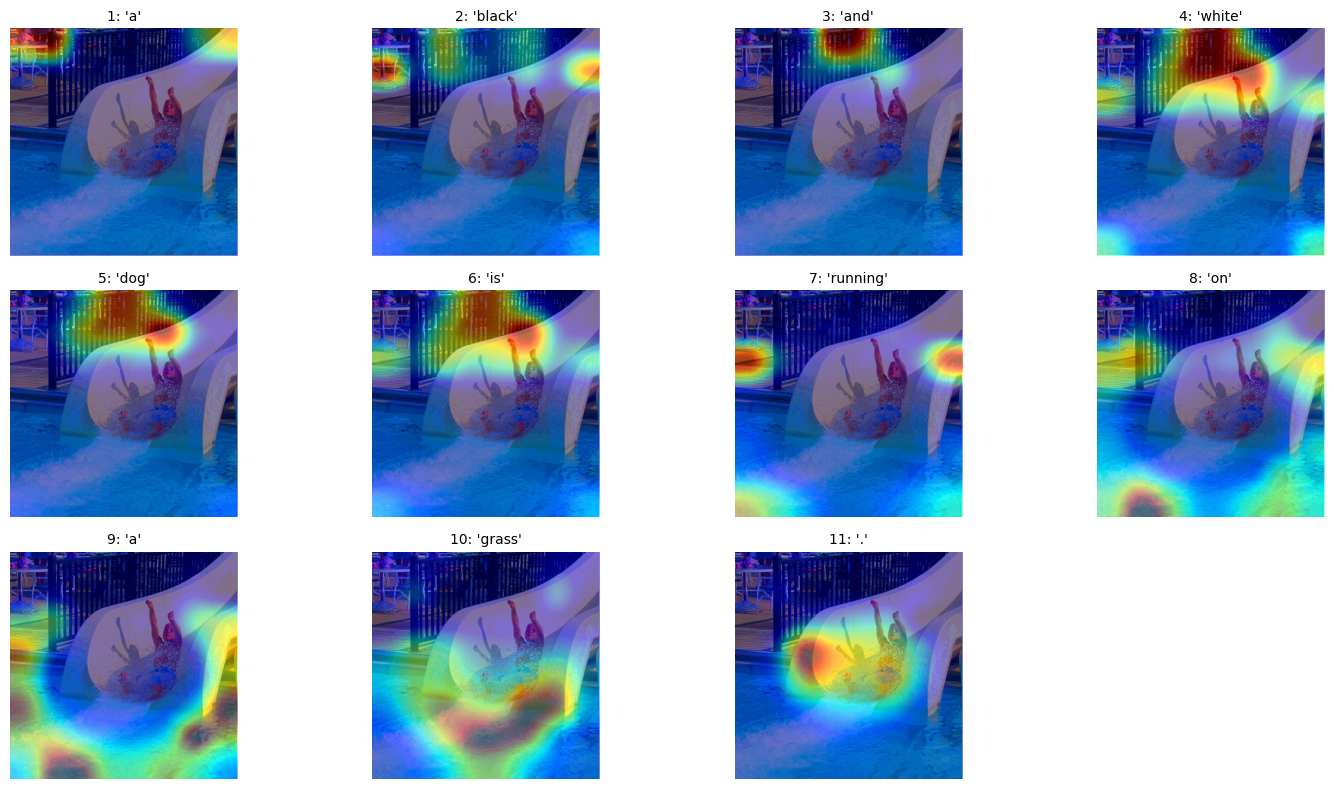

In [40]:
sample_pair = random.choice(processor.test_data)
sample_img = os.path.join(CONFIG['image_dir'], sample_pair[0])
model.demo(sample_img, filename='caption_audio01.mp3')

In [41]:
for batch in train_ds.take(1):
    img_tensor, tok_ids, _, filenames = batch
    fname = filenames[0].numpy().decode()

    decoded = ' '.join(
        processor.tokenizer.index_word.get(int(i), '')
        for i in tok_ids[0].numpy() if i)

    print("Filename :", fname)
    print("Caption  :", decoded)
    print("GT       :", processor.captions_dict[fname][0])

Filename : 1383840121_c092110917.jpg
Caption  : <start> a dog lying on a blue cloth dog bed . <end>
GT       : A brown dog laying on a blue cover .
